In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate

from astropy.table import Table
#import picca.wedgize
#import sys
#sys.path.append(‘C:\users\name\code\my-Python-object-location’)

import matplotlib.pyplot as plt
from desispec.interpolation import resample_flux
import timeit



18233.750000000004


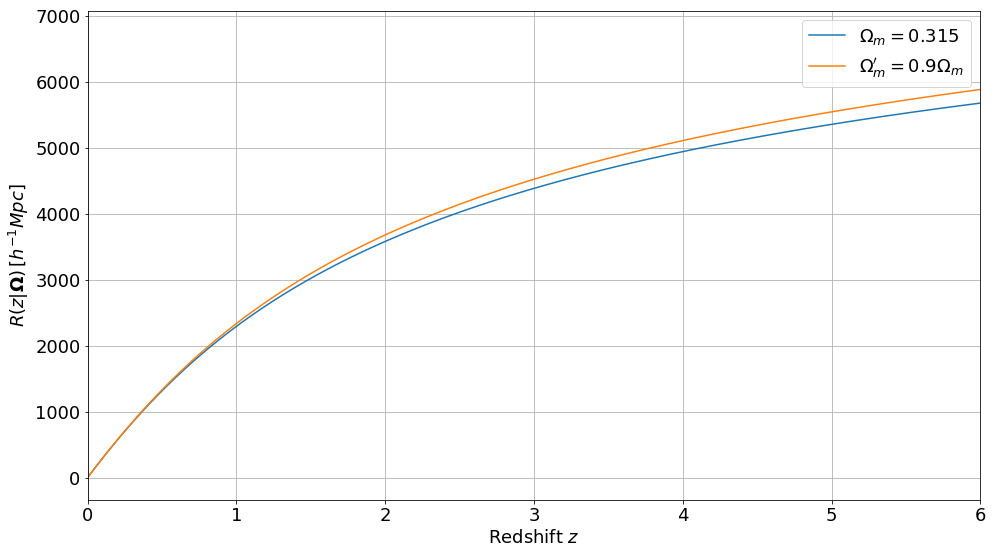

In [2]:
##### Plot for Rcomov Comparison between Omega and Omega_bld
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
plt.rcParams.update({'font.size': 18})

deg = sp.pi/180.

boss_lambda_min = 3600. ## Angstrom

from scipy.constants import speed_of_light as speed_light

small_angle_cut_off = 2./3600.*sp.pi/180. ## 2 arcsec

class cosmo:

    def __init__(self,Om,Ok=0.,Or=0.,wl=-1.,H0=100.):

        ### Ignore evolution of neutrinos from matter to radiation
        ### H0 in km/s/Mpc
        c = speed_light/1000. ## km/s
        Ol = 1.-Ok-Om-Or

        nbins = 100000
        zmax  = 15.
        dz    = zmax/nbins
        z=np.arange(nbins)*dz
        hubble = H0*np.sqrt( Ol*(1.+z)**(3.*(1.+wl)) + Ok*(1.+z)**2 + Om*(1.+z)**3 + Or*(1.+z)**4 )

        chi=np.zeros(nbins)
        for i in range(1,nbins):
            chi[i]=chi[i-1]+c*(1./hubble[i-1]+1./hubble[i])/2.*dz

        self.r_comoving = interpolate.interp1d(z,chi)

        ### dm here is the comoving angular diameter distance
        if Ok==0.:
            dm = chi
        elif Ok<0.:
            dm = sp.sin(H0*np.sqrt(-Ok)/c*chi)/(H0*np.sqrt(-Ok)/c)
        elif Ok>0.:
            dm = sp.sinh(H0*np.sqrt(Ok)/c*chi)/(H0*np.sqrt(Ok)/c)

        self.hubble = interpolate.interp1d(z,hubble)
        self.r_2_z = interpolate.interp1d(chi,z)

        ### D_H
        self.dist_hubble = interpolate.interp1d(z,c/hubble)
        ### D_M
        self.dm = interpolate.interp1d(z,dm)
        ### D_V
        y = np.power(z*self.dm(z)**2*self.dist_hubble(z),1./3.)
        self.dist_v = interpolate.interp1d(z,y)

### Absorber names and wavelengths [Angstrom]
absorber_IGM = {
    'LYA'         : 1215.67,
}

###### Definition of cosmological model
'''
   parser.add_argument('--fid-Om', type=float, default=0.315, required=False,
        help='Omega_matter(z=0) of fiducial LambdaCDM cosmology')

    parser.add_argument('--fid-Or', type=float, default=0., required=False,
        help='Omega_radiation(z=0) of fiducial LambdaCDM cosmology')

    parser.add_argument('--fid-Ok', type=float, default=0., required=False,
        help='Omega_k(z=0) of fiducial LambdaCDM cosmology')

    parser.add_argument('--fid-wl', type=float, default=-1., required=False,
        help='Equation of state of dark energy of fiducial LambdaCDM cosmology')
'''
fid_Om = 0.315
fid_Or = 0
fid_Ok = 0
fid_wl = -1

cosmo_m = cosmo(Om=fid_Om,Or=fid_Or,
        Ok=fid_Ok,wl=fid_wl)

lambda_abs = absorber_IGM['LYA']

###### Definition of Fake cosmological model

scale = .9

fid_Om = 0.315*scale
fid_Or = 0
fid_Ok = 0
fid_wl = -1

cosmo_m2 = cosmo(Om=fid_Om,Or=fid_Or,
        Ok=fid_Ok,wl=fid_wl)

lambda_abs = absorber_IGM['LYA']


zmax = 14
l_max = ( lambda_abs * (zmax + 1) ) - 1.3
print(l_max)

ll = np.log10( np.linspace(lambda_abs + .5, l_max, 10000) )

z = 10**ll/lambda_abs-1.

r_comov = cosmo_m.r_comoving(z)
r_comov2 = cosmo_m2.r_comoving(z)


znew = resample_flux(r_comov, r_comov2, z)

zmask = ( z <= 10 )


z = z[zmask]
znew = znew[zmask]
r_comov = r_comov[zmask]
r_comov2 = r_comov2[zmask]
ll = ll[zmask] 

llnew = np.log10( lambda_abs * ( znew + 1 ) )

#zmz = znew - z
zmz = -znew + z
#lol = 10**llnew / (10**ll)
lol = 10**ll / (10**llnew)



if 0:
    plt.figure()
    #plt.grid()
    plt.plot( 10**ll, lol, label=r'$\Omega_m^\prime = '+str(scale)+'\Omega_m $' )
    plt.xlabel(r'$\lambda [A]$')
    plt.ylabel(r'$\lambda_{\Omega_m^\prime} / \lambda$')
    plt.legend()

    plt.figure()
    plt.plot(z,zmz)
    #plt.grid()
    plt.xlabel(r'$Z$')
    plt.ylabel(r'$Z_{\Omega^{\prime}}- Z$')

    plt.rcParams.update({'font.size': 18})


plt.figure()
plt.plot( z, r_comov, label=r"$\Omega_m=0.315$")
#plt.plot( z, r_comov2, label=r"$\Omega_m^\prime="+str(scale)+"\Omega_m$")
plt.plot( z, r_comov2, label=r"$\Omega_m^\prime="+str(scale)+"\Omega_m$")

plt.xlabel(r'Redshift $z$')
plt.ylabel(r'$R(z| {\bf\Omega} ) \, [h^{-1} Mpc]$')
plt.xticks(np.arange(0, 10))
plt.xlim((0,6))

plt.legend()
plt.grid()




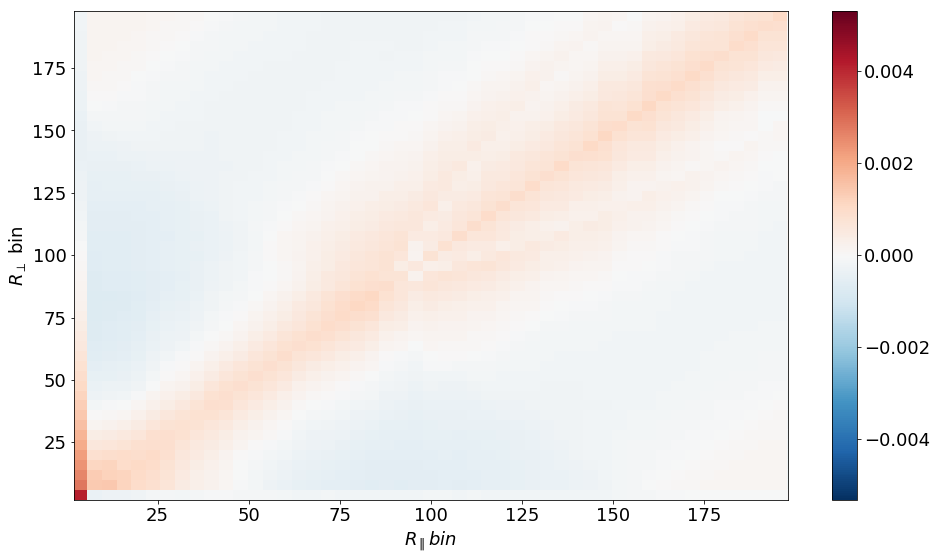

In [3]:
##### Plot for Dmat comparison

import numpy as np
import scipy as sp
from scipy import interpolate

from astropy.table import Table
#import picca.wedgize
import fitsio as fitsio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import h5py  #fit data
from matplotlib import cm
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
plt.rcParams.update({'font.size': 18})

# DM1
exp = Table.read('/global/homes/s/sfbeltr/respaldo/out_blinding/output-desi-Y1M/out/e_cf.fits.gz')

rp1 = exp['RP']
rt1 = exp['RT']
dm1 = exp['DM']
cov1 = exp['CO']

clim = np.max(dm1)
maxv = clim
dm1 = dm1/maxv

# DM3
exp = Table.read('/global/homes/s/sfbeltr/respaldo/out_blinding/output-desi-Y1MB-v2/out/e_cf.fits.gz')

rp3 = exp['RP']
rt3 = exp['RT']
dm3 = exp['DM']
cov3 = exp['CO']
dm3 = dm3/maxv

clim = np.max(dm1)

fig = plt.figure()
clim = (np.max( -( dm1 - dm3 ) ) )
plot = plt.pcolormesh(rp3, rp3,-( dm1 - dm3 ) , cmap=cm.RdBu_r, linewidth=0, antialiased=False,
                      vmin = -clim, vmax = clim, shading='auto')
fig.colorbar(plot)
plt.xlabel(r'$R_\parallel bin$')
plt.ylabel(r'$R_\perp$ bin')
# plt.title(r'( Dm - bld_DM )')
plt.show()



files:  1218


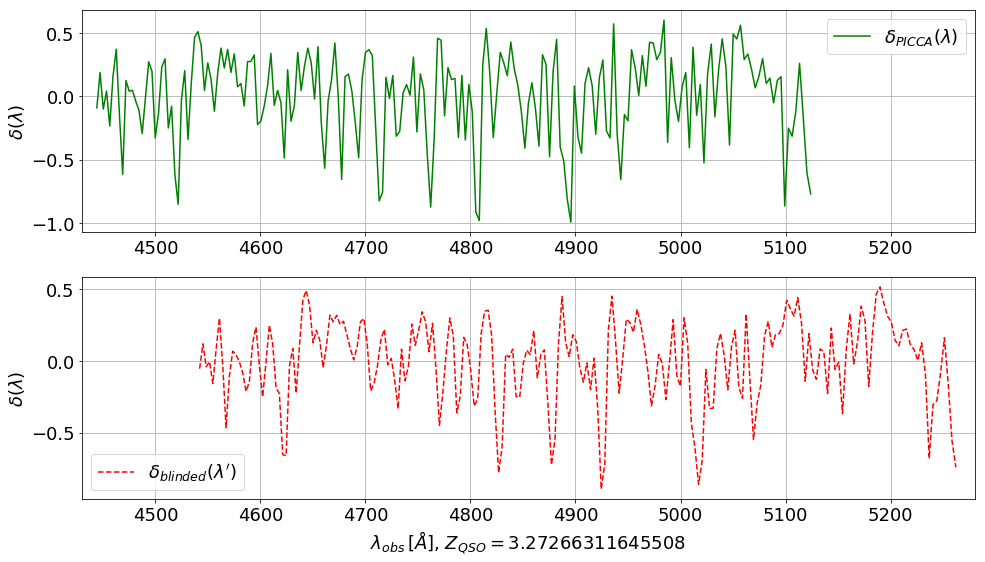

In [14]:
#### Delta comparison plot

#!/usr/bin/python

import sys

import numpy as np
from astropy.io import fits as pyfits
from desispec.interpolation import resample_flux

import os

import glob

#print('from: ', sys.argv[1], 'to: ', sys.argv[2] )

dir  = '/global/homes/s/sfbeltr/respaldo/out_blinding/output-desi-1.0-4/deltas/'

fi = sorted( glob.glob(dir+'*.fits*') )

lol_ = np.load('/global/u2/s/sfbeltr/respaldo/lya-blinding/lol.npy')
l_ = np.load('/global/u2/s/sfbeltr/respaldo/lya-blinding/l.npy')

Zmz_ = np.load('/global/u2/s/sfbeltr/respaldo/lya-blinding/zmz.npy')
Z_ = np.load('/global/u2/s/sfbeltr/respaldo/lya-blinding/z.npy')

print('files: ', len( fi ))

for i in range( 0, 1 ):   # len( fi )
   catalog = pyfits.open( fi[i] ) #,  mode='update')
   #print('\t File ', i-int(sys.argv[1])+1, ' of ', 11, fi[i] )
   for j in range(1, 2 ):
      #print('\t QSO ', j, ' of ', len(catalog), '.' )
      l_o = 10**catalog[j].data['LOGLAM']
      flux_o = catalog[j].data['DELTA']
      # Z QSO ap shift
      Za = catalog[j].header['Z']
      Z_rebin = np.interp( Za, Z_, Zmz_ )
      Zb = Za + Z_rebin
      # QSO forest ap shift with int. conserv.
      l = 10**( catalog[j].data['LOGLAM'] )
      lol_rebin = resample_flux( l, l_, lol_ )
      l_rebin = lol_rebin*l
      #l_rebin = l_rebin + l_rebin[int(len(l_rebin)/2)] - l[int(len(l)/2)]
      l2 = l-( l[-1]-l_rebin[-1] )
      l = l2
      # resample_flux(xout, x, flux, ivar=None, extrapolate=False):
      flux, ivar = resample_flux(l, l_rebin, catalog[j].data['DELTA'], ivar=catalog[j].data['WEIGHT'] )
      l1 = l
      flux1 = flux
   catalog.close()

fig, ax = plt.subplots(2,1)

xini = 4430
xend = 5280

ax[0].plot( l_o, flux_o, 'g',label=r'$\delta_{PICCA}(\lambda)$')  
ax[0].set_xlim((xini,xend))                     # 4330,5150
ax[0].grid()
ax[0].legend()

ax[0].set(ylabel=r'$ \delta(\lambda) $')

llog = np.log10(l_o)

l2 = 10**(  np.arange( np.log10( np.min(l_rebin) ), np.log10( np.max(l_rebin) ), llog[1]-llog[0] )    )
flux2, ivar2 = resample_flux(l2, l_rebin, catalog[j].data['DELTA'], ivar=catalog[j].data['WEIGHT'] )

#ax[1].plot(l1, flux1, 'b',label=r'$\delta_{blinded, \lambda_{PICCA}}(\lambda)$')
ax[1].plot(l2, flux2, 'r--',label=r'$\delta_{blinded}(\lambda^{\prime})$')
ax[1].set_xlim((xini,xend))
ax[1].set(ylabel=r'$ \delta(\lambda) $')

plt.xlabel(r'$ \lambda_{obs} \, [\AA]$' + ', ' + r'$Z_{QSO} = $'+str(Za) )
plt.ylabel(r'$ \delta(\lambda) $')


plt.legend()
plt.grid()